# Tree and Boosting models
## Tree

Data download:

In [19]:
set.seed(123)
data <- read.csv(file.path("..","..", "data", "training_data.csv"))
data <- na.omit(data)
data$PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

In [20]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]
dim(data)

[1]  708 3029

Division into train and test set. 

In [21]:
idx <- sample(nrow(data), 4*nrow(data)/5)

#matrix
train.x <- data[idx,]
train.x$PL <- NULL
train.x <- as.matrix(train.x)
train.y <- data$PL[idx]

test.x <- data[-idx,]
test.x$PL <- NULL
test.x <- as.matrix(test.x)
test.y <- data$PL[-idx]

#data.frame
train.set = data[idx,]
test.set = data[-idx,]


First, we create a simple tree on the train set to observe a first analysis in order to improve it. 

In [6]:
library(tree)

tree.pl <- tree(PL ~ ., data = train.set)
summary(tree.pl)


Regression tree:
tree(formula = PL ~ ., data = train.set)
Variables actually used in tree construction:
 [1] "RDF015s"  "Mor31i"   "G.O..S."  "RDF060s"  "Mor07m"   "Mor21s"  
 [7] "R4s."     "R4p."     "R2i"      "ATSC1s"   "Dm"       "Mor10u"  
[13] "WiA_G.D"  "Mor24e"   "R4e."     "H3v"      "MATS8p"   "RDF035u" 
[19] "GATS3p"   "H1e"      "DLS_cons" "CIC5"     "E3s"     
Number of terminal nodes:  24 
Residual mean deviance:  281.6 = 152600 / 542 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-52.760  -9.397   0.250   0.000  10.400  44.240 

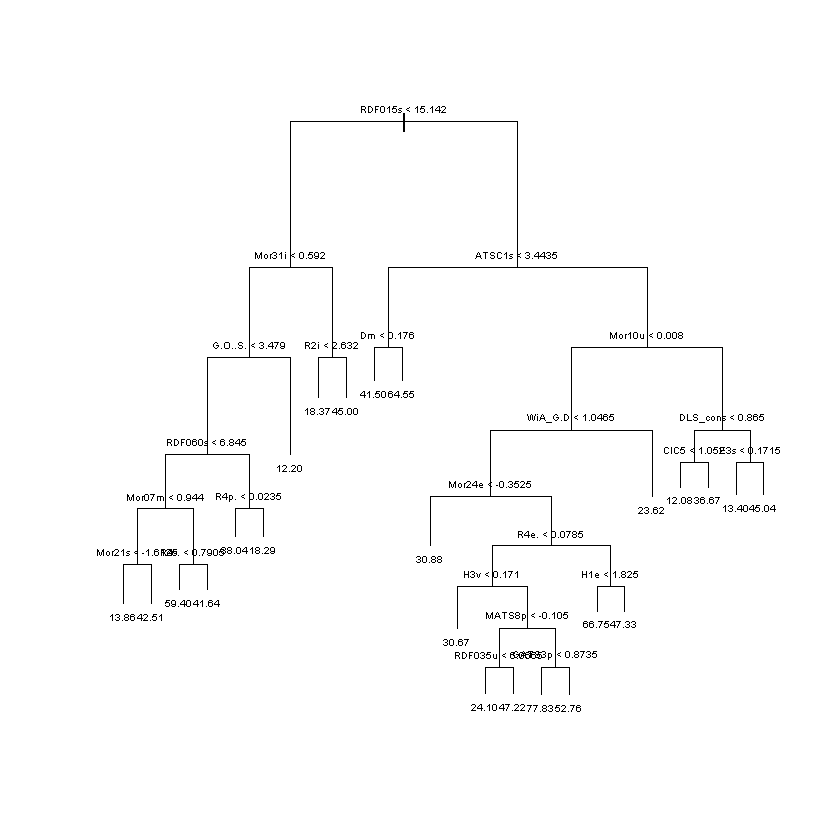

In [7]:
plot(tree.pl)
text(tree.pl, pretty=0, cex=0.5)

This tree has 24 nodes. 

Calculation of the mean squared error: 

In [8]:
y.pred <- predict(tree.pl, newdata = test.set)
paste('The MSE of this tree is', mean((y.pred-test.y)^2)) 

[1] "The MSE of this tree is 559.741400958161"

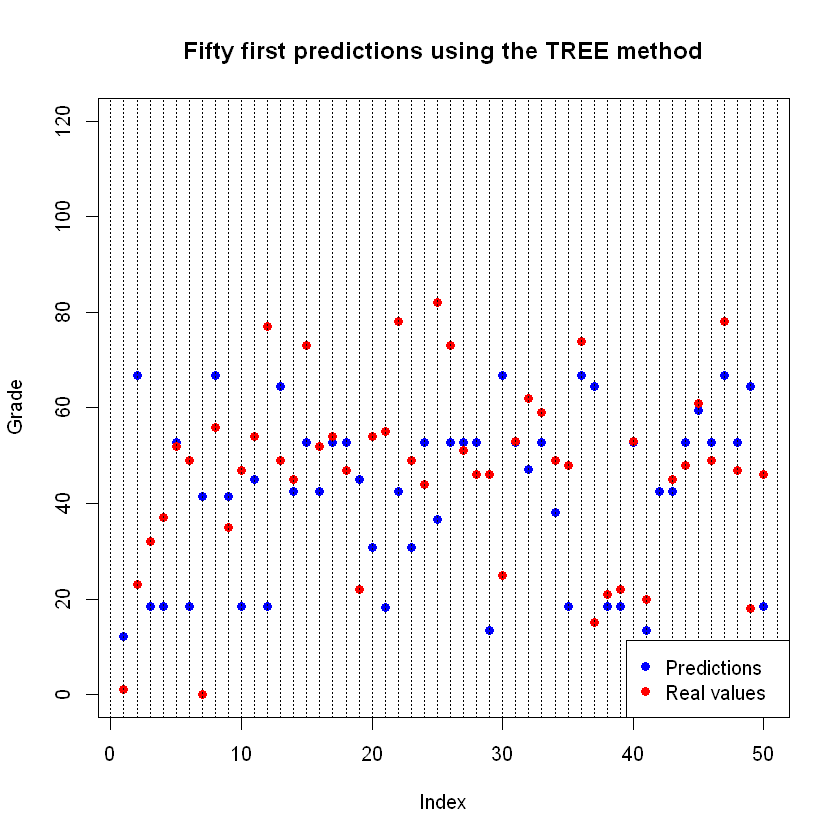

In [9]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using the TREE method')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The MSE is better than directly applied a linear regression. However, the lasso regularization gives us better results. 

Therefore, we can now perform a cross-validation test to optimize and find a better tree finding the best size. It is also a solution to avoid overfitting.

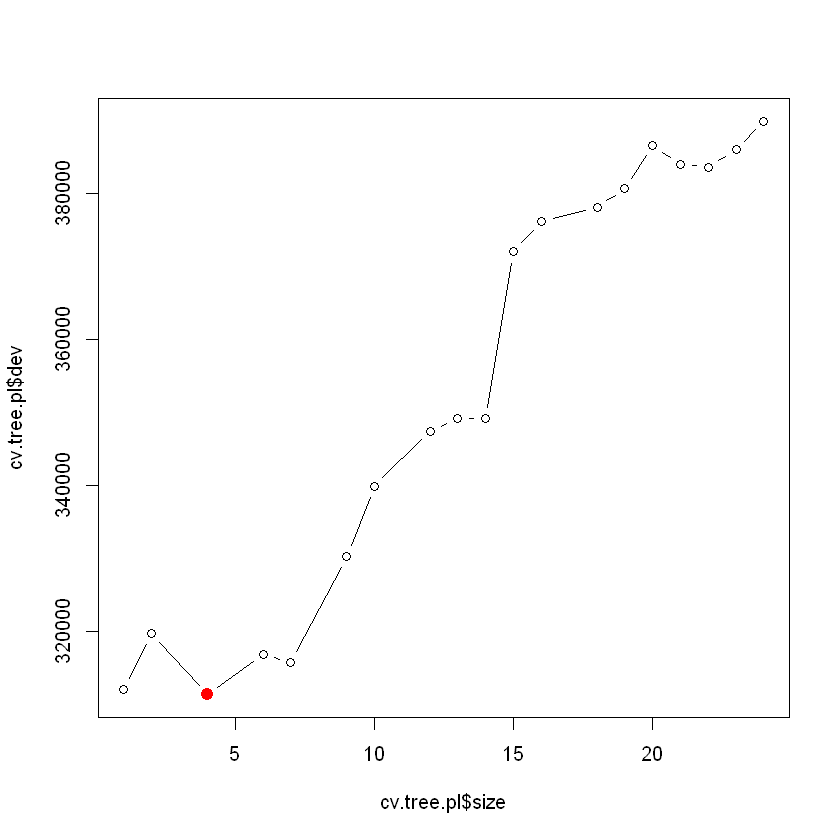

In [14]:
set.seed(23)
cv.tree.pl <- cv.tree(tree.pl)
plot(cv.tree.pl$size, cv.tree.pl$dev, type='b')
tree.min <- which.min(cv.tree.pl$dev)
points(cv.tree.pl$size[tree.min], cv.tree.pl$dev[tree.min], col='red', cex=2, pch=20)

We find here the best size is 4, selected by CV. 

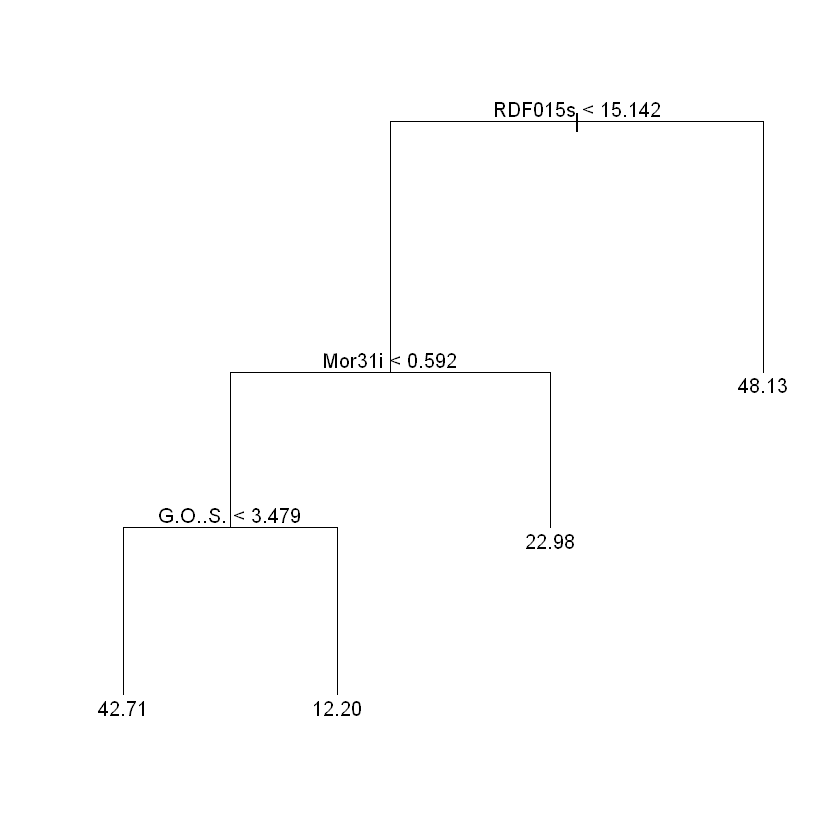

In [16]:
prune.tree.pl <- prune.tree(tree.pl, best = cv.tree.pl$size[tree.min])
plot(prune.tree.pl)
text(prune.tree.pl, pretty=0)

In [17]:
y.pred <- predict(prune.tree.pl, newdata = test.set)
paste('The MSE of the prune tree is', mean((y.pred-test.y)^2)) 

[1] "The MSE of the prune tree is 501.326044921193"

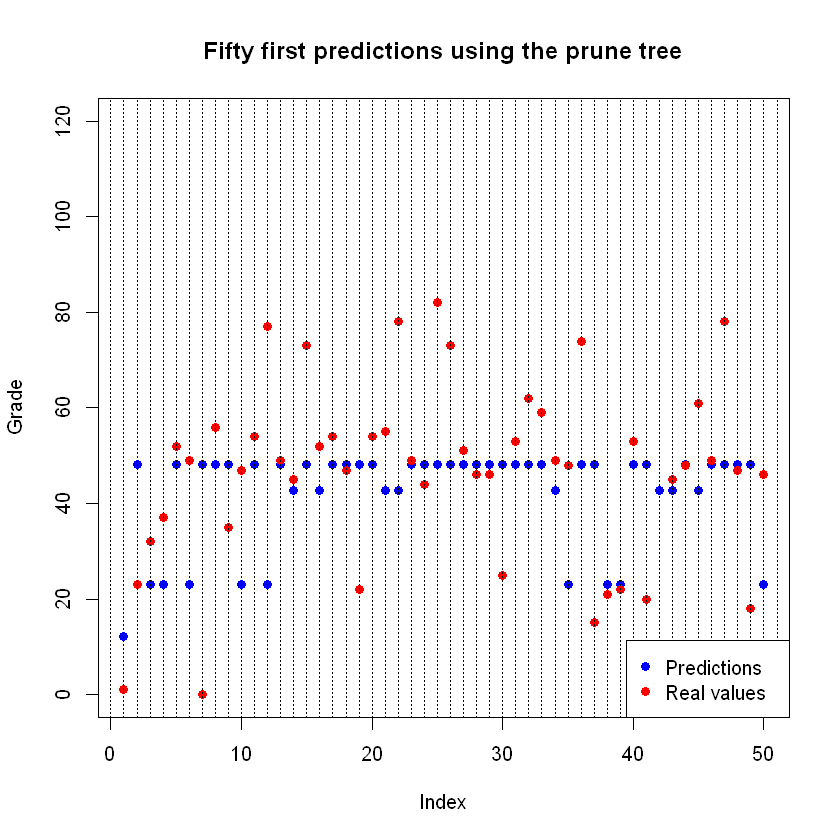

In [18]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using the prune tree')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

By calculation, we find a lower MSE. However, when we plot the prediction values, we observe they are too concentrated at approximately 50. The model underfits.


## Boosting 

The boosting method should well improve the results.  

In [4]:
library(xgboost)

By setting at 1000 trees, we want to find the best shrinkage value to minimise the mean squared error. 

In [5]:
set.seed(1)
pows <- seq(-3.5, -0.2, by = 0.1)
lambdas <- 10^pows

train.err <- rep(NA, length(lambdas))
test.err <- rep(NA, length(lambdas))

for (i in 1:length(lambdas)) {
    boost.pl <- xgboost(train.x, label=train.y, eta=lambdas[i], objective="reg:squarederror", max.depth=3, nrounds=1000, verbose = 0)
    pred.train <- predict(boost.pl, train.x)
    pred.test <- predict(boost.pl, test.x)
    train.err[i] <- mean((pred.train - train.y)^2)
    test.err[i] <- mean((pred.test - test.y)^2)
}

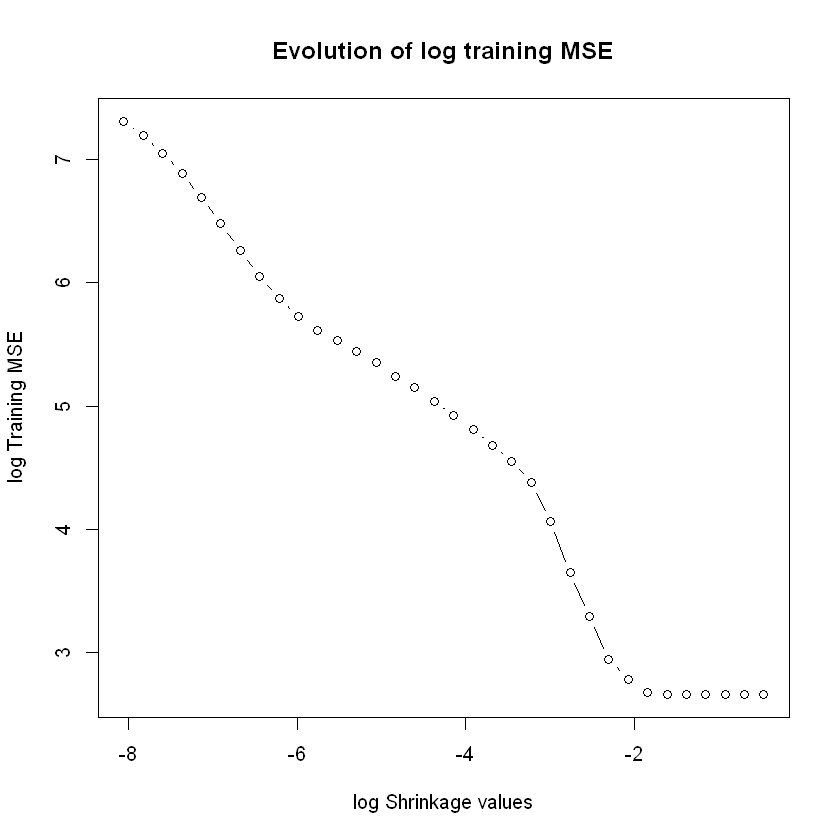

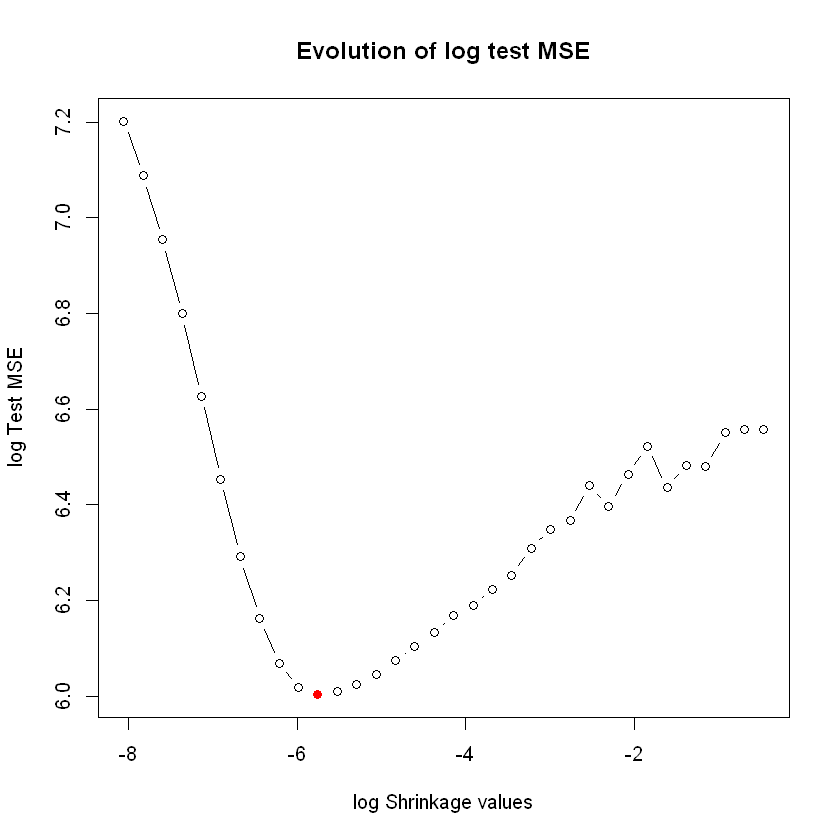

In [6]:
#training MSE
plot(log(lambdas), log(train.err), type="b", xlab="log Shrinkage values", ylab="log Training MSE")
title('Evolution of log training MSE')

#Test MSE
plot(log(lambdas), log(test.err), type="b", xlab="log Shrinkage values", ylab="log Test MSE")
points(log(lambdas[which.min(test.err)]), log(min(test.err)), col='red', pch=19)
title('Evolution of log test MSE')

In [7]:
paste('The minimum test error is', min(test.err))
paste('The optimal shrinkage is', lambdas[which.min(test.err)])

[1] "The minimum test error is 404.595091315944"

[1] "The optimal shrinkage is 0.00316227766016838"

We evaluate the boosting model with different possible $\lambda$ in order to avoid overfit or underfit of the prediction data.

Here, the model we found above and its prediction plot:

In [8]:
set.seed(1)
boost.pl <- xgboost(train.x, label=train.y, eta=lambdas[which.min(test.err)], objective="reg:squarederror", max.depth=3, nrounds=1000, verbose = 0)
y.pred <- predict(boost.pl, test.x)
test.error <- mean((y.pred - test.y)^2) 

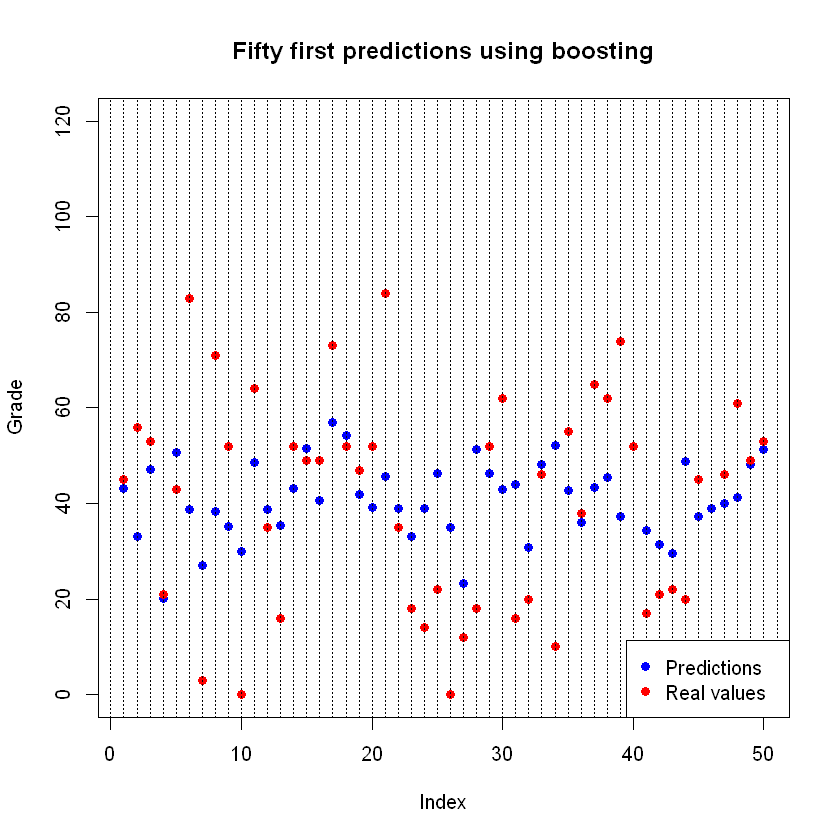

In [9]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using boosting')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

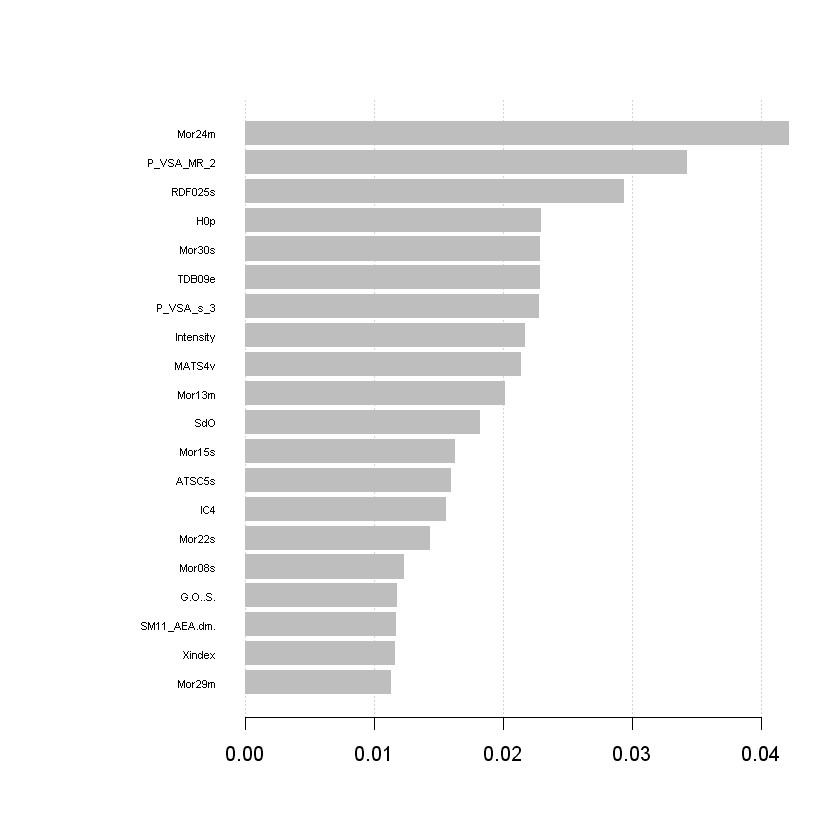

In [10]:
importance <- xgb.importance(model=boost.pl)
xgb.plot.importance(importance_matrix = importance, top_n = 20)

Here, the first 20 most important predictors are plotted.

To have another and more precise tuning, we can create a hyper_grid which contains different values of $\lambda$ and maximal size 'max_depth'. Then, we perform a cross-validation:

In [22]:
# create hyperparameter grid
hyper_grid <- expand.grid(
  eta = c(.001, .005, .01, .1),
  max_depth = c(1, 3, 5, 7)  
)

In [23]:
library(keras)
library(xgboost)

In [24]:
# grid search 
for(i in 1:nrow(hyper_grid)) {
  
  # create parameter list
  params <- list(
    eta = hyper_grid$eta[i],
    max_depth = hyper_grid$max_depth[i],
    objective = 'reg:squarederror'
  )
  
  # reproducibility
  set.seed(123)
  
  # train model
  xgb.tune <- xgb.cv(
    params = params,
    data = train.x,
    label = train.y,
    nrounds = 5000,
    nfold = 10,
    verbose = 0,               # silent,
    early_stopping_rounds = 10 # stop if no improvement for 10 consecutive trees
  )
# add min training error and trees to grid
  hyper_grid$optimal_trees[i] <- which.min(xgb.tune$evaluation_log$test_rmse_mean)
  hyper_grid$min_RMSE[i] <- min(xgb.tune$evaluation_log$test_rmse_mean)
}
  

In [25]:
hyper_grid %>%
  dplyr::arrange(min_RMSE)

eta,max_depth,optimal_trees,min_RMSE
<dbl>,<dbl>,<int>,<dbl>
0.100,1,132,21.91673
0.010,1,1117,21.97160
0.005,1,2169,21.98345
0.100,3,33,22.35975
0.005,3,703,22.42727
0.010,3,341,22.44340
0.001,3,3273,22.46035
0.001,1,5000,22.46496
0.001,5,2640,23.34753


For simplicity, we assume the first one and we can make a test to have an overview of the prediction with this process with our test set: 


In [36]:
set.seed(123)
boost.pl <- xgboost(train.x, label=train.y, eta=0.1, objective="reg:squarederror", max.depth=1, nrounds=132, verbose = 0)
y.pred <- predict(boost.pl, test.x)
test.error <- mean((y.pred - test.y)^2) 
paste('MSE =', test.error)

[1] "MSE = 418.245083500542"

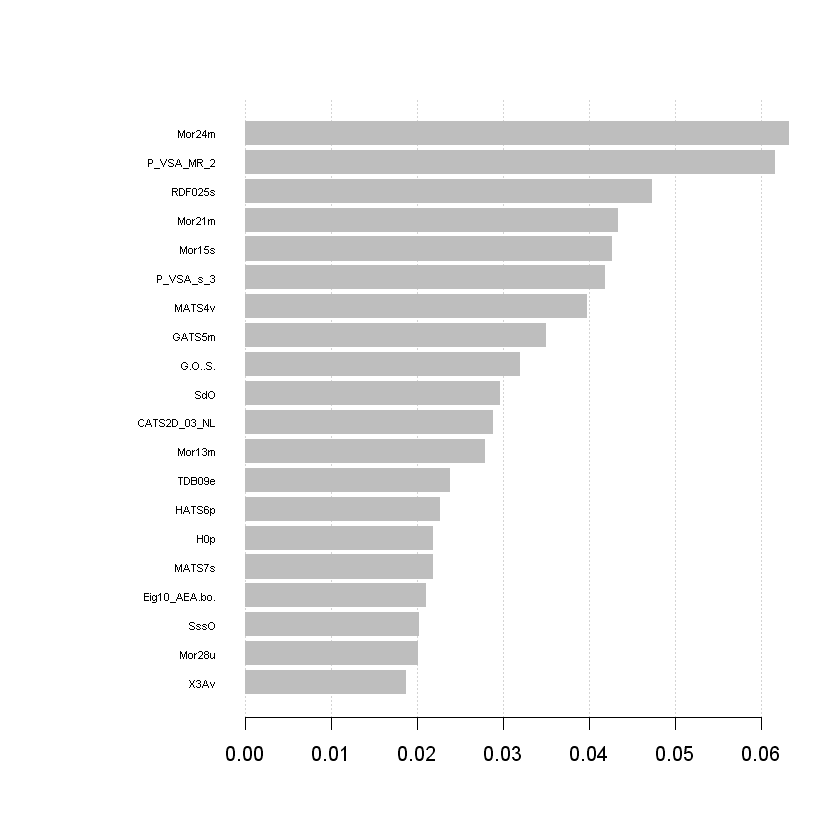

In [37]:
importance <- xgb.importance(model=boost.pl)
xgb.plot.importance(importance_matrix = importance, top_n = 20)

The importance graph shows the same first predictors: mor24m and P_VSA_MR_2. 

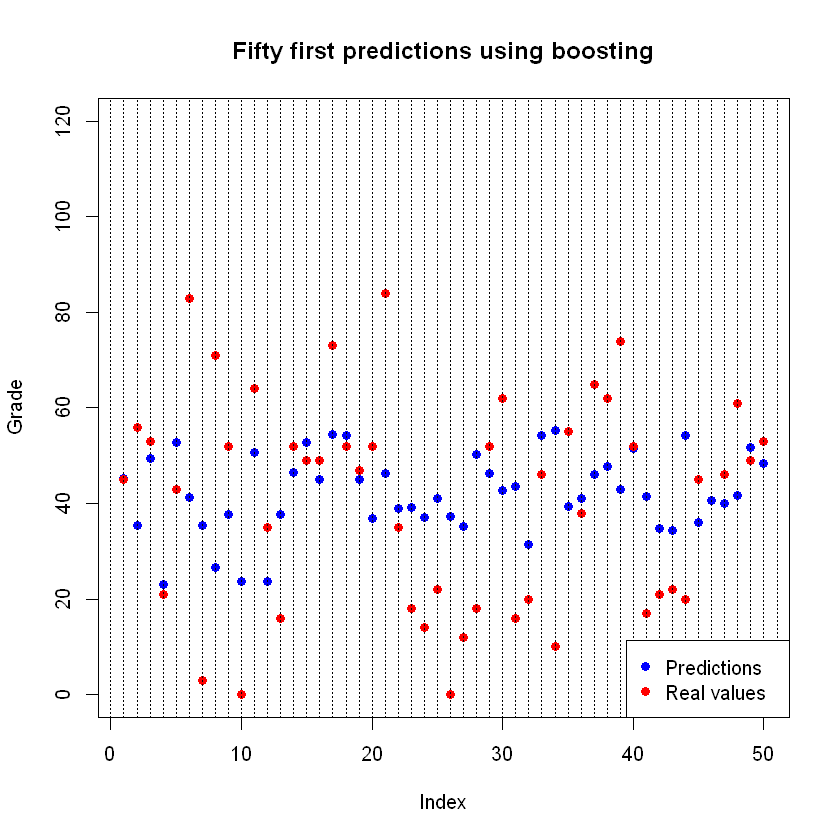

In [38]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using boosting')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

This graph allows us to control if with this process the data over- or underfit. Now, we can fit the best model on all the training set by cross-validation.  

### Boosting with cross-validation (tuning of the best model)

In [39]:
set.seed(123)
data <- read.csv(file.path("..","..", "data", "training_data.csv"))
data <- na.omit(data)
data$PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

In [40]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]

In [41]:
data.x <- data
data.x$PL <- NULL
data.x <- as.matrix(data.x)
data.y <- data$PL

In [42]:
library(xgboost)
library(keras)

In [33]:
# create hyperparameter grid
hyper_grid <- expand.grid(
  eta = c(.001, .005, .01, .1),
  max_depth = c(1, 3, 5, 7)  
)

In [34]:
# grid search 
for(i in 1:nrow(hyper_grid)) {
  
  # parameter list
  params <- list(
    eta = hyper_grid$eta[i],
    max_depth = hyper_grid$max_depth[i],
    objective = 'reg:squarederror'
  )
  
  # for reproducibility
  set.seed(123)
  
  # train model
  xgb.tune <- xgb.cv(
    params = params,
    data = data.x,
    label = data.y,
    nrounds = 5000,
    nfold = 10,
    verbose = 0,               # silent,
    early_stopping_rounds = 10 # stop if no improvement for 10 consecutive trees
  )
# add min test error and trees to grid
  hyper_grid$optimal_trees[i] <- which.min(xgb.tune$evaluation_log$test_rmse_mean)
  hyper_grid$min_RMSE[i] <- min(xgb.tune$evaluation_log$test_rmse_mean)
}

In [35]:
hyper_grid %>%
  dplyr::arrange(min_RMSE)

eta,max_depth,optimal_trees,min_RMSE
<dbl>,<dbl>,<int>,<dbl>
0.100,1,203,21.45567
0.005,1,2608,21.62270
0.010,1,1201,21.65681
0.010,3,362,21.80871
0.005,3,703,21.81462
0.001,3,3411,21.82047
0.100,3,34,21.91180
0.001,1,5000,22.10325
0.010,5,293,22.53965


In [46]:
#Final model
set.seed(123)
boost.pl <- xgboost(data.x, label=data.y, eta=0.1, objective="reg:squarederror", max.depth=1, nrounds=203, verbose = 0)

### Random Forest
Comparison with the bagging and random forest without particular tuning: 

In [82]:
library(randomForest)
set.seed(123)
bag <- randomForest(PL ~ ., data=train.set, mtry = ncol(train.x), ntree = 1000)
pred.bag <- predict(bag, newdata=test.x)
mean((pred.bag-test.y)^2)

[1] 435.3679

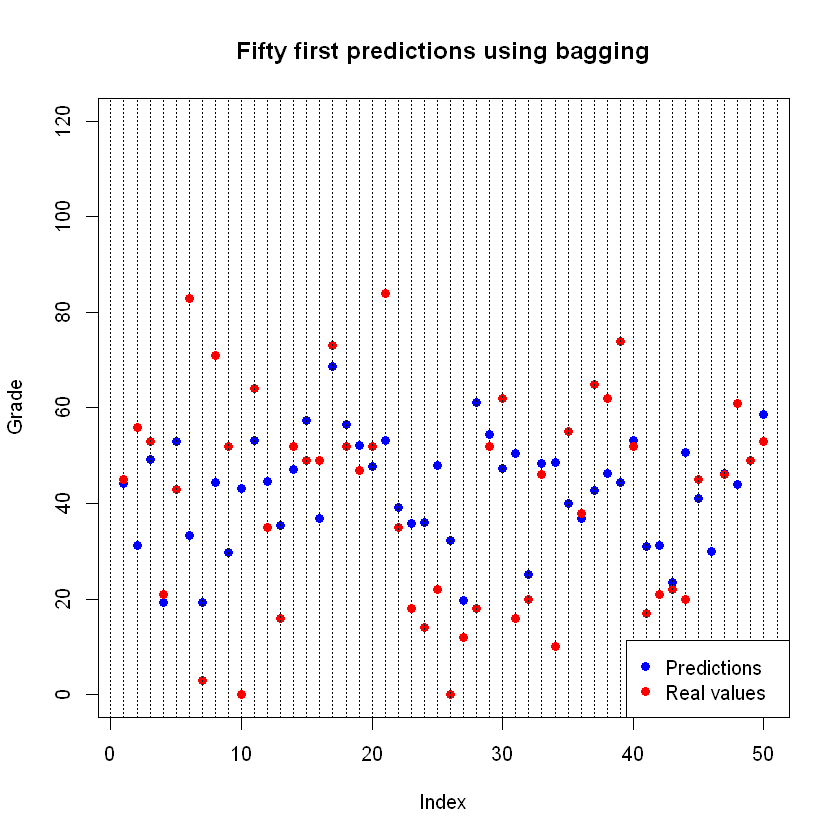

In [83]:
plot(pred.bag[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using bagging')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

Random forest: $m \approx\frac{p}{3}$, the default value for regression model.

In [84]:
set.seed(123)
bag <- randomForest(PL ~ ., data=train.set, ntree = 1000)
pred.rf <- predict(bag, newdata=test.x)
paste('The MSE of random forest model is', mean((pred.rf-test.y)^2))

[1] "The MSE of random forest model is 443.680661473317"

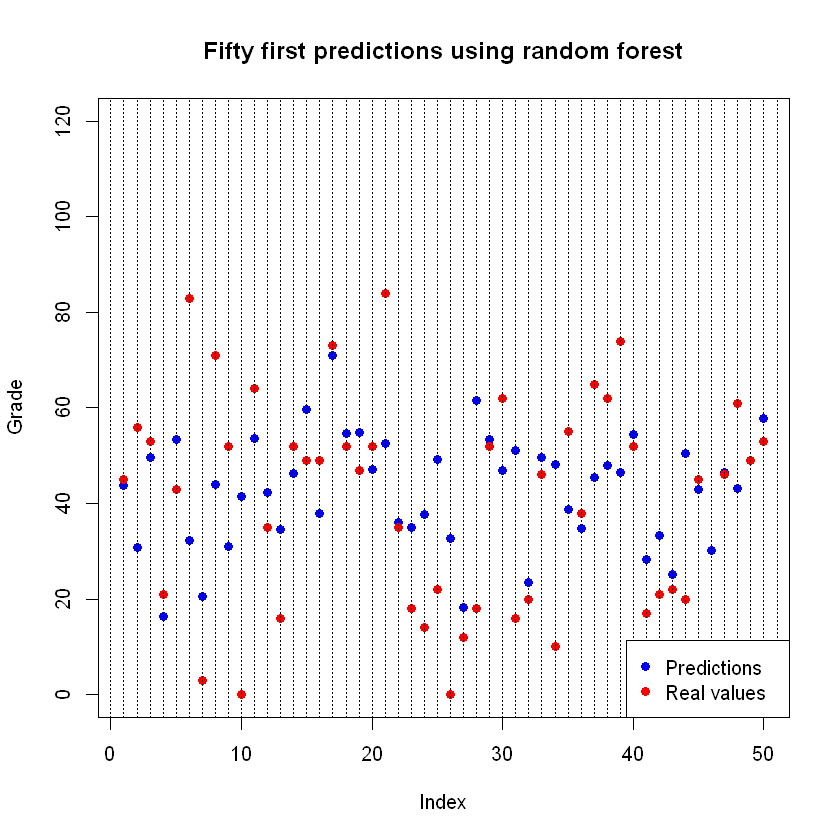

In [85]:
plot(pred.rf[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using random forest')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The boosting method gives us a better MSE than bagging and the random forest models. However, they are not tuned. We ust wanted to compare a bit. 